In [3]:
import numpy as np
import pandas as pd #manipulation des données, calculs.
import pandas_datareader.data as web #téléchargement de données financières via API.
import matplotlib.pyplot as plt
from matplotlib import style 
import seaborn as sns
import yfinance as yf
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import datetime as dt

C:\Users\alexa\AppData\Local\Temp\ipykernel_26848\3122854082.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(TICKER, start, end)
[*********************100%***********************]  1 of 1 completed


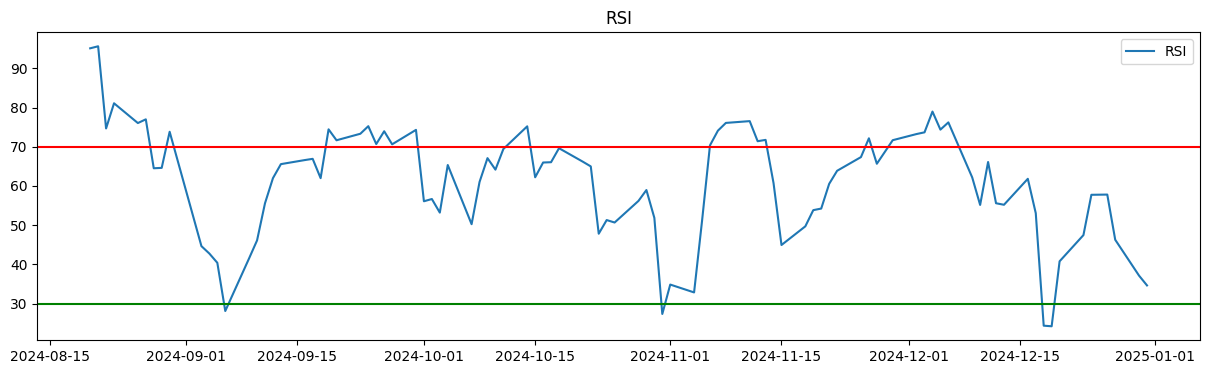

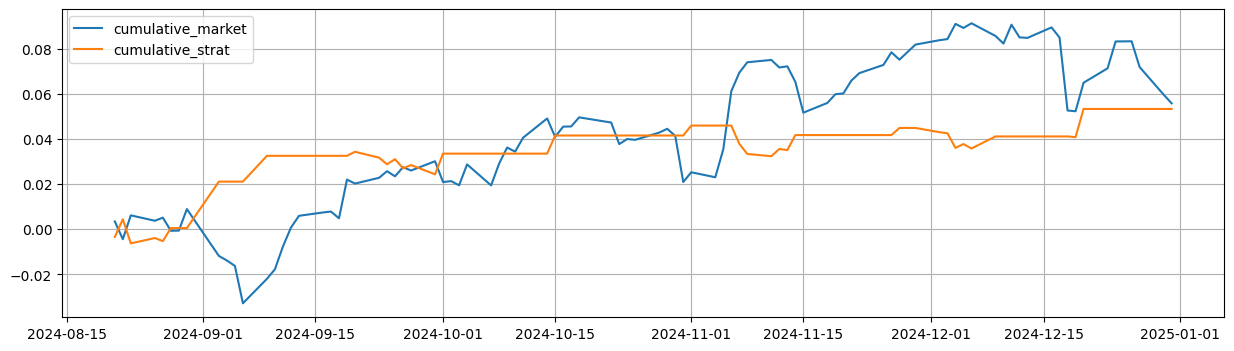

In [42]:
TICKER = 'SPY' 
RSI_LENGTH = 14
OVERBOUGTH = 70
UNDERBOUGTH = 30
LOOKBACK = 100

def get_data():
    start = dt.datetime(1980,1,1)
    end = dt.datetime(2025,1,1)
    df = yf.download(TICKER, start, end)
    df.columns = df.columns.get_level_values(0)
    return df.iloc[-LOOKBACK:, :]

df = get_data()

def add_RSI(df):
    df["delta"] = df['Close'].diff()
    df["gains"] = df["delta"].clip(lower = 0) # met tout ce qui est en dessous de 0 à 0 (garde seulement les hausses)
    df["pertes"] = -df["delta"].clip(upper = 0)
    df["moy_gains"] = df["gains"].ewm(span = RSI_LENGTH, adjust = False).mean() # adjust = False pour avoir le EMA qui correspond a celui de Trading view
    df["moy_pertes"] = df["pertes"].ewm(span = RSI_LENGTH, adjust = False).mean()
    df["RS"] = df["moy_gains"]/df["moy_pertes"].replace(0, np.nan) # on calcul notre RS et on remplace 0 par nan qui sera supprimer à la fin de tt facon
    df["RSI"] = 100 - (100/(1+df["RS"])) # RSI valeur entre 0 et 100
    return df.dropna()

df = add_RSI(df)

def add_strat(df):
    df["strat"] = np.where(df["RSI"] > OVERBOUGTH, -1, np.where(UNDERBOUGTH > df["RSI"], 1, 0)) # double condition (astuce sympa)
    return df

df = add_strat(df)

def test_strat(df):
    df["market_return"] = df["Close"].pct_change()
    df['strat_return'] = df["market_return"] * df['strat'].shift(1)

    df["cumulative_market"] = (1+df["market_return"]).cumprod() -1
    df["cumulative_strat"] = (1+df["strat_return"]).cumprod() -1

    return df


df = test_strat(df)

# observer RSI
plt.figure(figsize =(15,4))
plt.plot(df["RSI"], label = "RSI")
plt.axhline(OVERBOUGTH, color = 'red')
plt.axhline(UNDERBOUGTH, color = 'green')
plt.title("RSI")
plt.legend()
plt.show()

# Visulaser le cumulatif
plt.figure(figsize = (15,4))
plt.plot(df['cumulative_market'])
plt.plot(df['cumulative_strat'])
plt.legend(['cumulative_market', 'cumulative_strat'])
plt.grid()


In [13]:
df["Close"] 

Date
2021-01-11    354.542725
2021-01-12    354.617584
2021-01-13    355.572510
2021-01-14    354.327393
2021-01-15    351.743317
                 ...    
2024-12-24    596.076965
2024-12-26    596.116699
2024-12-27    589.841614
2024-12-30    583.110596
2024-12-31    580.989136
Name: Close, Length: 1000, dtype: float64